<a href="https://colab.research.google.com/github/anvichip/automate-stocks-sentiments/blob/main/macd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
!pip install yfinance
!pip install --upgrade yfinance

In [197]:
import pandas as pd
import yfinance as yf

In [198]:
#Get Stocks using stock code and days
def get_stocks(stock_code, days):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.Timedelta(days=days)

    # Download stock data using yfinance
    stock_data = yf.download(stock_code, start=start_date, end=end_date)

    # Reset index and create a 'Date' column from the index
    stock_data_reset = stock_data.reset_index()
    stock_data_reset['Date'] = stock_data_reset['Date'].dt.date

    return stock_data_reset


In [199]:
#Main function

stock_code = "GABRIEL.NS"
days = 365
df = get_stocks(stock_code,days)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-09-05,166.800003,171.850006,166.350006,167.000000,164.908310,834555
1,2022-09-06,168.300003,169.850006,162.500000,165.500000,163.427109,619203
2,2022-09-07,164.250000,170.899994,163.500000,169.649994,167.525116,495831
3,2022-09-08,171.000000,171.899994,165.600006,166.600006,164.513336,372822
4,2022-09-09,168.800003,170.399994,166.250000,167.600006,165.500809,390411


In [200]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [201]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [202]:
# Define the get_macd function
def get_macd(price, slow, fast, smooth):
    exp1 = price['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = price['Close'].ewm(span=slow, adjust=False).mean()

    macd = pd.DataFrame(exp1 - exp2).rename(columns={'Close': 'macd'})
    signal = macd.ewm(span=smooth, adjust=False).mean().rename(columns={'macd': 'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns={0: 'hist'})

    frames = [price['Date'], macd, signal, hist]
    df = pd.concat(frames, join='inner', axis=1)
    return df

In [203]:
# Calculate MACD for the provided dataset
macd = get_macd(df, 26, 12, 9)
macd.tail()

,Date,macd,signal,hist
243,2023-08-28,22.720278,14.055499,8.664779
244,2023-08-29,25.435906,16.331580,9.104326
245,2023-08-30,26.830932,18.431450,8.399482
246,2023-08-31,27.689930,20.283146,7.406784
247,2023-09-01,28.155073,21.857532,6.297541


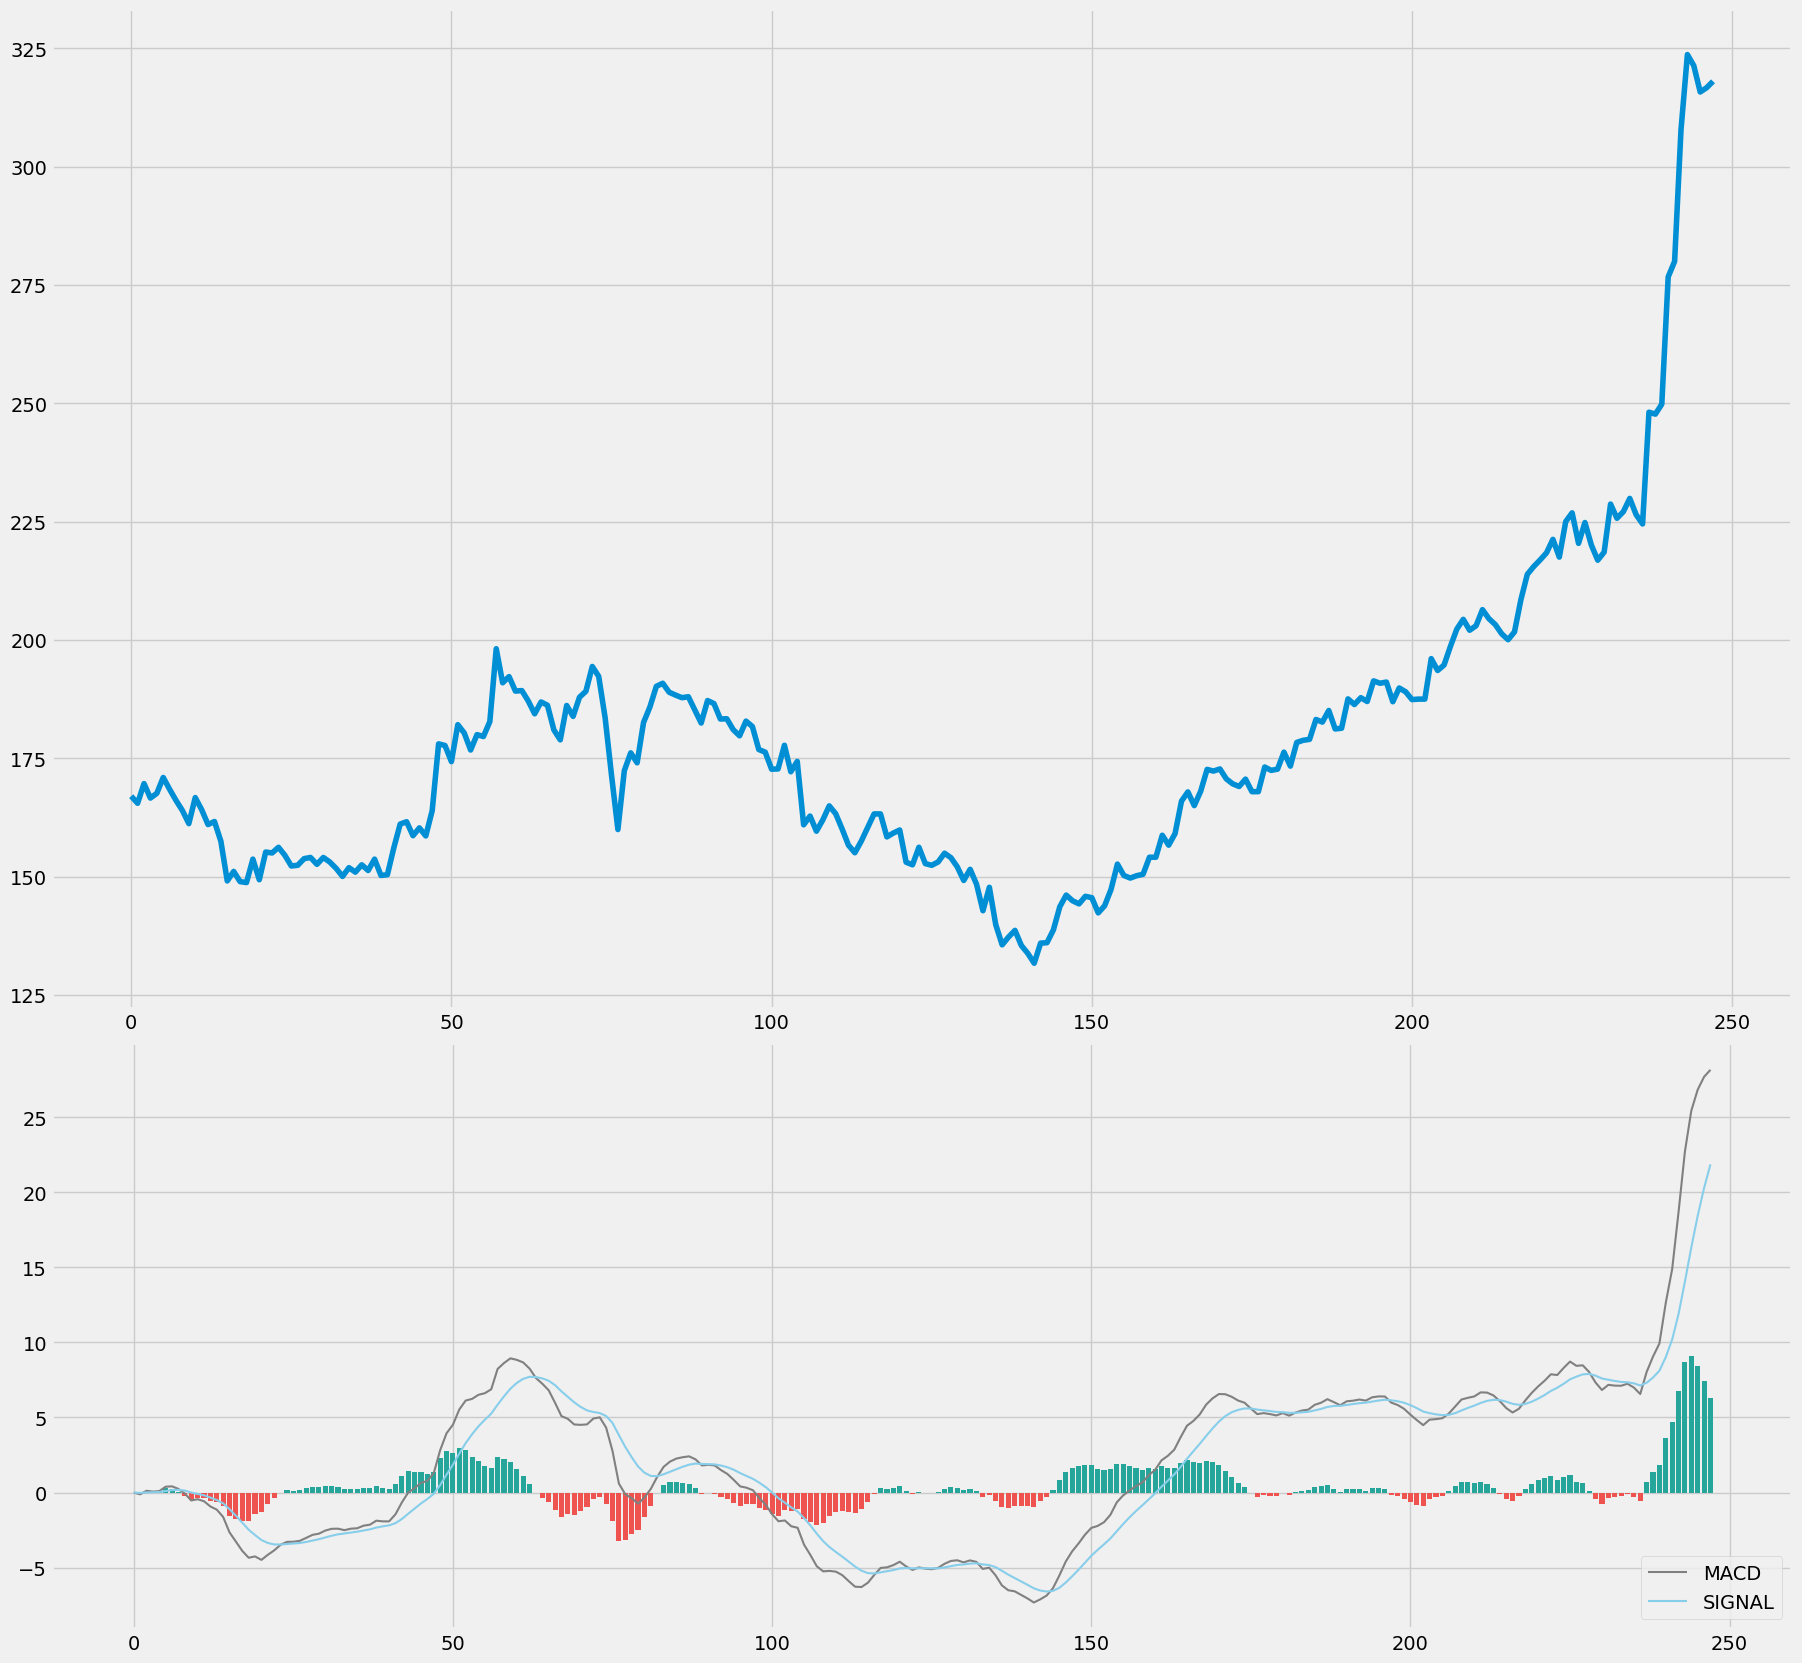

In [204]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
plt.style.use('fivethirtyeight')

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['Close'], macd['macd'], macd['signal'], macd['hist'])

In [205]:
import numpy as np

def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(df['Close'], macd)

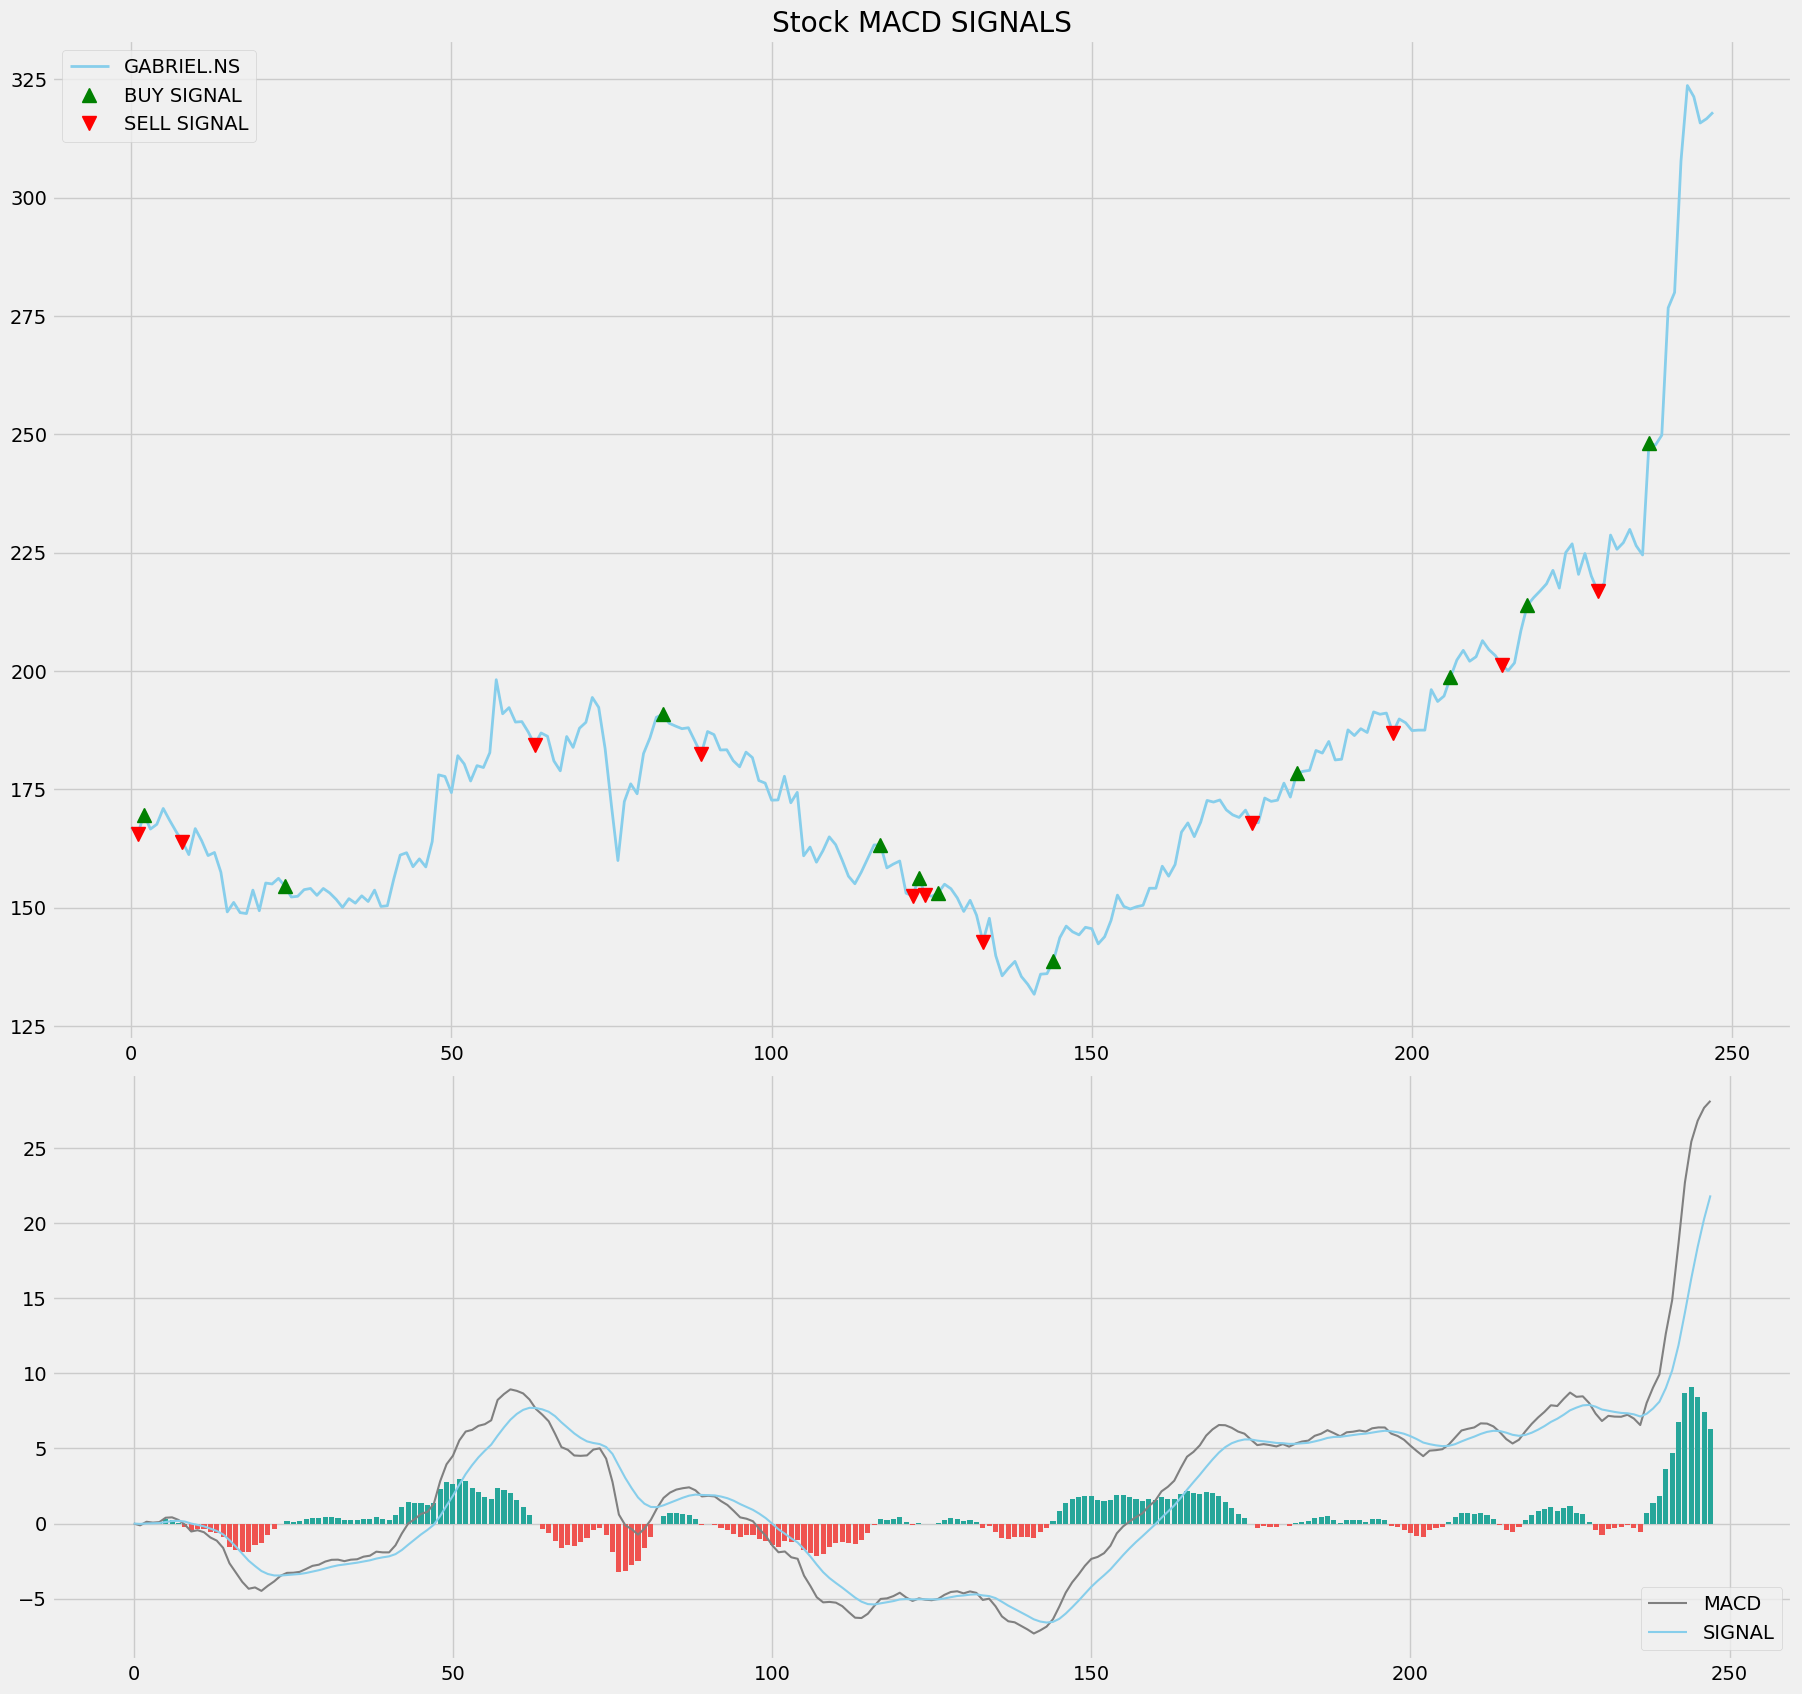

In [206]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['Close'], color = 'skyblue', linewidth = 2, label = stock_code)
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('Stock MACD SIGNALS')
ax2.plot(macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(macd)):
    if str(macd['hist'][i])[0] == '-':
        ax2.bar(macd.index[i], macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(macd.index[i], macd['hist'][i], color = '#26a69a')

plt.legend(loc = 'lower right')
plt.show()

In [207]:
# Merge the two dataframes on the "Date" column
merged_df = pd.merge(df, macd, on="Date")
merged_df

,Date,Open,High,Low,Close,Adj Close,Volume,macd,signal,hist
0,2022-09-05,166.800003,171.850006,166.350006,167.000000,164.908310,834555,0.000000,0.000000,0.000000
1,2022-09-06,168.300003,169.850006,162.500000,165.500000,163.427109,619203,-0.119658,-0.023932,-0.095726
2,2022-09-07,164.250000,170.899994,163.500000,169.649994,167.525116,495831,0.119010,0.004657,0.114353
3,2022-09-08,171.000000,171.899994,165.600006,166.600006,164.513336,372822,0.061340,0.015993,0.045347
4,2022-09-09,168.800003,170.399994,166.250000,167.600006,165.500809,390411,0.095231,0.031841,0.063390
...,...,...,...,...,...,...,...,...,...,...
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,323.649994,4164391,22.720278,14.055499,8.664779
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,321.299988,1716976,25.435906,16.331580,9.104326
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,315.750000,679698,26.830932,18.431450,8.399482
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,316.649994,468158,27.689930,20.283146,7.406784


In [208]:
# Add the macd_signal column to the merged dataframe
merged_df['macd_signal'] = macd_signal
merged_df


,Date,Open,High,Low,Close,Adj Close,Volume,macd,signal,hist,macd_signal
0,2022-09-05,166.800003,171.850006,166.350006,167.000000,164.908310,834555,0.000000,0.000000,0.000000,0
1,2022-09-06,168.300003,169.850006,162.500000,165.500000,163.427109,619203,-0.119658,-0.023932,-0.095726,-1
2,2022-09-07,164.250000,170.899994,163.500000,169.649994,167.525116,495831,0.119010,0.004657,0.114353,1
3,2022-09-08,171.000000,171.899994,165.600006,166.600006,164.513336,372822,0.061340,0.015993,0.045347,0
4,2022-09-09,168.800003,170.399994,166.250000,167.600006,165.500809,390411,0.095231,0.031841,0.063390,0
...,...,...,...,...,...,...,...,...,...,...,...
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,323.649994,4164391,22.720278,14.055499,8.664779,0
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,321.299988,1716976,25.435906,16.331580,9.104326,0
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,315.750000,679698,26.830932,18.431450,8.399482,0
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,316.649994,468158,27.689930,20.283146,7.406784,0


In [209]:
merged_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'macd',
       'signal', 'hist', 'macd_signal'],
      dtype='object')

# ML model

In [210]:
df = merged_df

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Features for training (excluding 'Date' and 'macd_signal')
df = df.drop(['Adj Close','macd_signal'], axis=1)

df

,Date,Open,High,Low,Close,Volume,macd,signal,hist
0,2022-09-05,166.800003,171.850006,166.350006,167.000000,834555,0.000000,0.000000,0.000000
1,2022-09-06,168.300003,169.850006,162.500000,165.500000,619203,-0.119658,-0.023932,-0.095726
2,2022-09-07,164.250000,170.899994,163.500000,169.649994,495831,0.119010,0.004657,0.114353
3,2022-09-08,171.000000,171.899994,165.600006,166.600006,372822,0.061340,0.015993,0.045347
4,2022-09-09,168.800003,170.399994,166.250000,167.600006,390411,0.095231,0.031841,0.063390
...,...,...,...,...,...,...,...,...,...
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,4164391,22.720278,14.055499,8.664779
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,1716976,25.435906,16.331580,9.104326
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,679698,26.830932,18.431450,8.399482
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,468158,27.689930,20.283146,7.406784


In [211]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [212]:
data = df

In [213]:
# Selecting the relevant columns
features = ['High', 'Low', 'Close', 'Volume', 'macd', 'signal', 'hist']
target = ['Open']

data_features = data[features]
data_target = data[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_open = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_open.fit(X_train, y_train.values.ravel())

# Predicting on the test set
y_pred = random_forest_open.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 20.34775305648233


In [214]:
X_test.shape

(50, 7)

In [215]:
# Create a new DataFrame
sno = np.arange(1, len(y_pred) + 1)
result_data = pd.DataFrame({'Sno': sno, 'y_test': y_test.values.ravel(), 'y_pred': y_pred})

result_data.head()

,Sno,y_test,y_pred
0,1,153.000000,153.097501
1,2,171.949997,169.642502
2,3,173.350006,175.011001
3,4,189.000000,189.489499
4,5,151.199997,150.736000


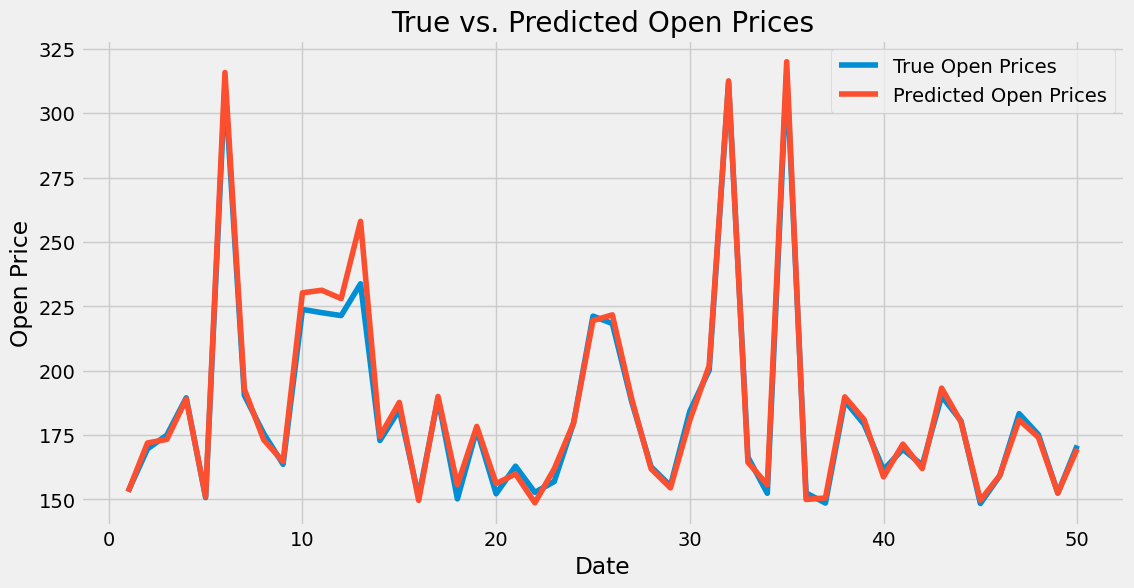

In [216]:
# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(result_data['Sno'], result_data['y_pred'], label='True Open Prices')
plt.plot(result_data['Sno'], result_data['y_test'], label='Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('True vs. Predicted Open Prices')
plt.legend()
plt.show()

In [217]:
df.tail()

,Date,Open,High,Low,Close,Volume,macd,signal,hist
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,4164391,22.720278,14.055499,8.664779
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,1716976,25.435906,16.331580,9.104326
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,679698,26.830932,18.431450,8.399482
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,468158,27.689930,20.283146,7.406784
247,2023-09-01,316.950012,321.700012,316.500000,318.000000,452734,28.155073,21.857532,6.297541


In [218]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Calculate the average of each column for the last 7 days' data
average_values = data.iloc[-7:].drop(columns=['Open']).mean()
next_day_open = random_forest_open.predict(average_values.values.reshape(1, -1))

# Print or use the predicted Close price as needed
print("Predicted Close Price for the Next Day:", next_day_open[0])


Predicted Close Price for the Next Day: 304.94200103759766


<ipython-input-218-bf23b0d9ca49>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_values = data.iloc[-7:].drop(columns=['Open']).mean()
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [219]:
# import pandas as pd

# def get_last_value(df, column_name):
#     # Get the last value of the specified column
#     last_value = df[column_name].iloc[-1]
#     return float(last_value)



# column_name = 'Open'
# last_value = get_last_value(df, column_name)
# print(f"Last value of '{column_name}' column: {last_value}")


In [220]:
# def predict_price_for_tomorrow(model, current_data):
#     # Assuming 'current_data' contains the features for tomorrow
#     tomorrow_features = current_data[['High', 'Low', 'Close', 'Volume', 'macd', 'signal', 'hist']]

#     # Predicting the price for tomorrow
#     predicted_price = model.predict(tomorrow_features)
#     return predicted_price

In [221]:
# # Get the last values
# last_high = get_last_value(df, 'High')
# last_low = get_last_value(df, 'Low')
# last_close = get_last_value(df, 'Close')
# last_volume = get_last_value(df, 'Volume')
# last_macd = get_last_value(df, 'macd')
# last_signal = get_last_value(df, 'signal')
# last_hist = get_last_value(df, 'hist')

# # Create a dictionary with the last values
# current_data_for_tomorrow = {
#     'High': last_high,
#     'Low': last_low,
#     'Close': last_close,
#     'Volume': last_volume,
#     'macd': last_macd,
#     'signal': last_signal,
#     'hist': last_hist
# }

# # Convert the dictionary to a DataFrame
# current_data_for_tomorrow_df = pd.DataFrame([current_data_for_tomorrow])

# # Call the prediction function for tomorrow's price
# predicted_tomorrow_price = predict_price_for_tomorrow(random_forest_open, current_data_for_tomorrow_df)
# print(f"Predicted price for tomorrow: {predicted_tomorrow_price[0]}")

Model to predict Closing Price

In [222]:
data = df

In [223]:
# Selecting the relevant columns
features = ['High', 'Low', 'Open', 'Volume', 'macd', 'signal', 'hist']
target = ['Close']

data_features = data[features]
data_target = data[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_close = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_close.fit(X_train, y_train.values.ravel())

# Predicting on the test set
y_pred = random_forest_close.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 5.064803792762797


In [224]:
# Create a new DataFrame
sno = np.arange(1, len(y_pred) + 1)
result_data = pd.DataFrame({'Sno': sno, 'y_test': y_test.values.ravel(), 'y_pred': y_pred})

result_data.head()

,Sno,y_test,y_pred
0,1,150.050003,151.548997
1,2,168.449997,168.276002
2,3,178.350006,173.966501
3,4,187.800003,187.561002
4,5,149.699997,149.442998


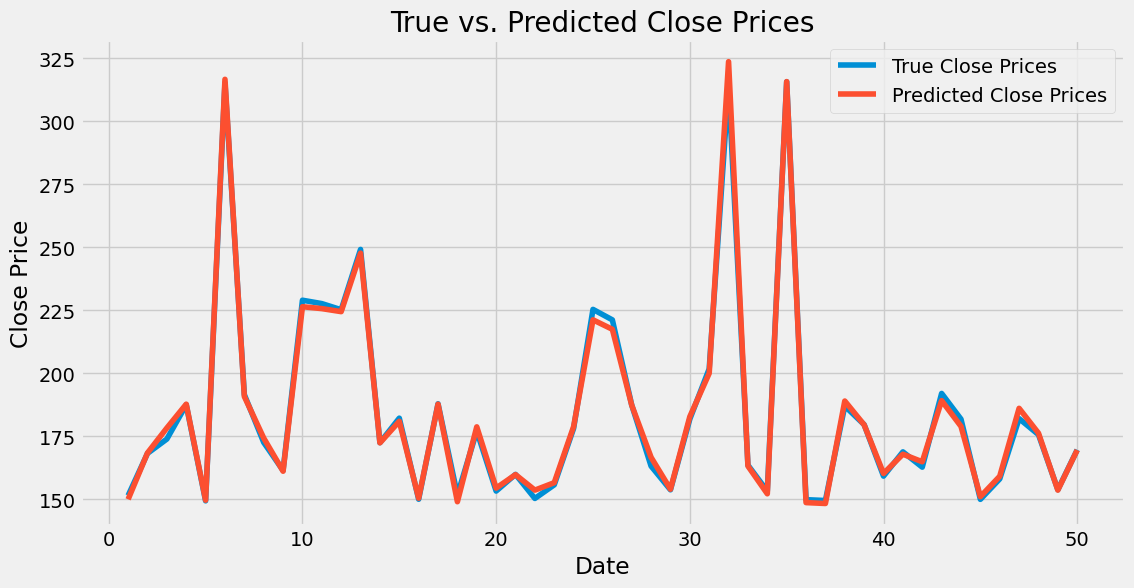

In [225]:
# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(result_data['Sno'], result_data['y_pred'], label='True Close Prices')
plt.plot(result_data['Sno'], result_data['y_test'], label='Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('True vs. Predicted Close Prices')
plt.legend()
plt.show()

In [226]:
df.tail()

,Date,Open,High,Low,Close,Volume,macd,signal,hist
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,4164391,22.720278,14.055499,8.664779
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,1716976,25.435906,16.331580,9.104326
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,679698,26.830932,18.431450,8.399482
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,468158,27.689930,20.283146,7.406784
247,2023-09-01,316.950012,321.700012,316.500000,318.000000,452734,28.155073,21.857532,6.297541


In [227]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Calculate the average of each column for the last 7 days' data
average_values = data.iloc[-7:].drop(columns=['Close']).mean()
next_day_close = random_forest_close.predict(average_values.values.reshape(1, -1))

# Print or use the predicted Close price as needed
print("Predicted Close Price for the Next Day:", next_day_close[0])


Predicted Close Price for the Next Day: 311.1504981994629


<ipython-input-227-46cb03bd3c33>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_values = data.iloc[-7:].drop(columns=['Close']).mean()
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Random Forest Model for High

In [228]:
# Selecting the relevant columns
features = ['Open', 'Low', 'Close', 'Volume', 'macd', 'signal', 'hist']
target = ['High']

data_features = data[features]
data_target = data[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_high = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_high.fit(X_train, y_train.values.ravel())

# Predicting on the test set
y_pred = random_forest_high.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.271826103024358


In [229]:
# Create a new DataFrame
sno = np.arange(1, len(y_pred) + 1)
result_data = pd.DataFrame({'Sno': sno, 'y_test': y_test.values.ravel(), 'y_pred': y_pred})

result_data.head()

,Sno,y_test,y_pred
0,1,153.449997,153.389500
1,2,172.300003,172.726999
2,3,179.850006,178.302997
3,4,190.399994,190.883000
4,5,151.850006,152.616501


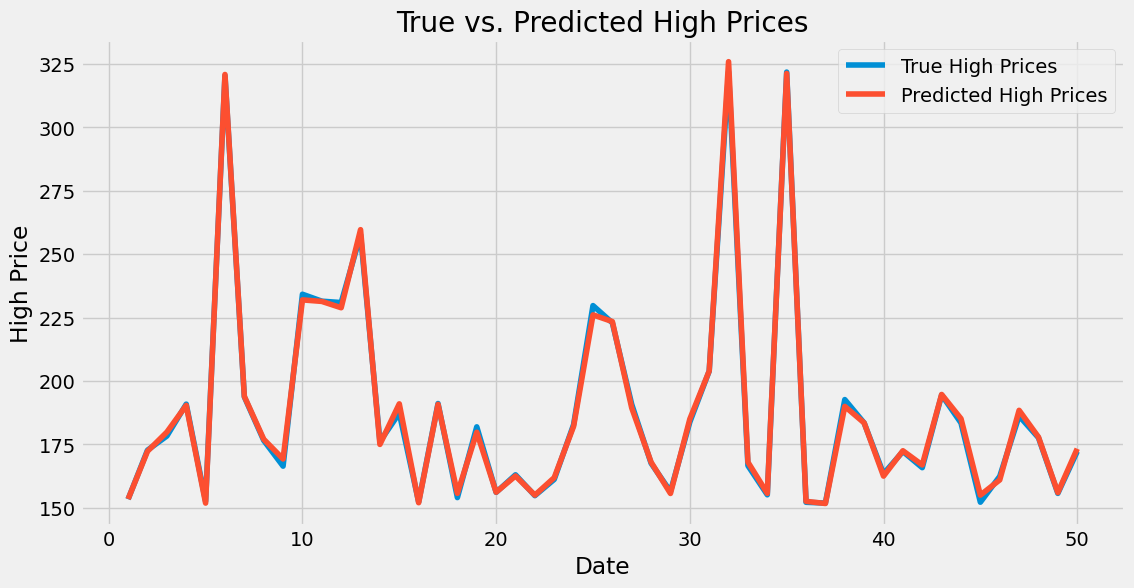

In [230]:
# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(result_data['Sno'], result_data['y_pred'], label='True High Prices')
plt.plot(result_data['Sno'], result_data['y_test'], label='Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('True vs. Predicted High Prices')
plt.legend()
plt.show()

In [231]:
df.tail()

,Date,Open,High,Low,Close,Volume,macd,signal,hist
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,4164391,22.720278,14.055499,8.664779
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,1716976,25.435906,16.331580,9.104326
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,679698,26.830932,18.431450,8.399482
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,468158,27.689930,20.283146,7.406784
247,2023-09-01,316.950012,321.700012,316.500000,318.000000,452734,28.155073,21.857532,6.297541


In [232]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Calculate the average of each column for the last 7 days' data
average_values = df.iloc[-7:].drop(columns=['High']).mean()
next_day_high = random_forest_close.predict(average_values.values.reshape(1, -1))

# Print or use the predicted Close price as needed
print("Predicted Close Price for the Next Day:", next_day_high[0])


Predicted Close Price for the Next Day: 311.5204975891113


<ipython-input-232-a4567cde9188>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_values = df.iloc[-7:].drop(columns=['High']).mean()
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Random Forest for Volume

In [233]:
# Selecting the relevant columns
features = ['Open', 'Low', 'Close', 'High', 'macd', 'signal', 'hist']
target = ['Volume']

data_features = data[features]
data_target = data[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_vol = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_vol.fit(X_train, y_train.values.ravel())

# Predicting on the test set
y_pred = random_forest_vol.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 403433768353.8209


In [234]:
# Create a new DataFrame
sno = np.arange(1, len(y_pred) + 1)
result_data = pd.DataFrame({'Sno': sno, 'y_test': y_test.values.ravel(), 'y_pred': y_pred})

result_data.head()

,Sno,y_test,y_pred
0,1,144556,138707.48
1,2,361946,485041.76
2,3,657729,491295.26
3,4,302229,350848.10
4,5,232177,416013.79


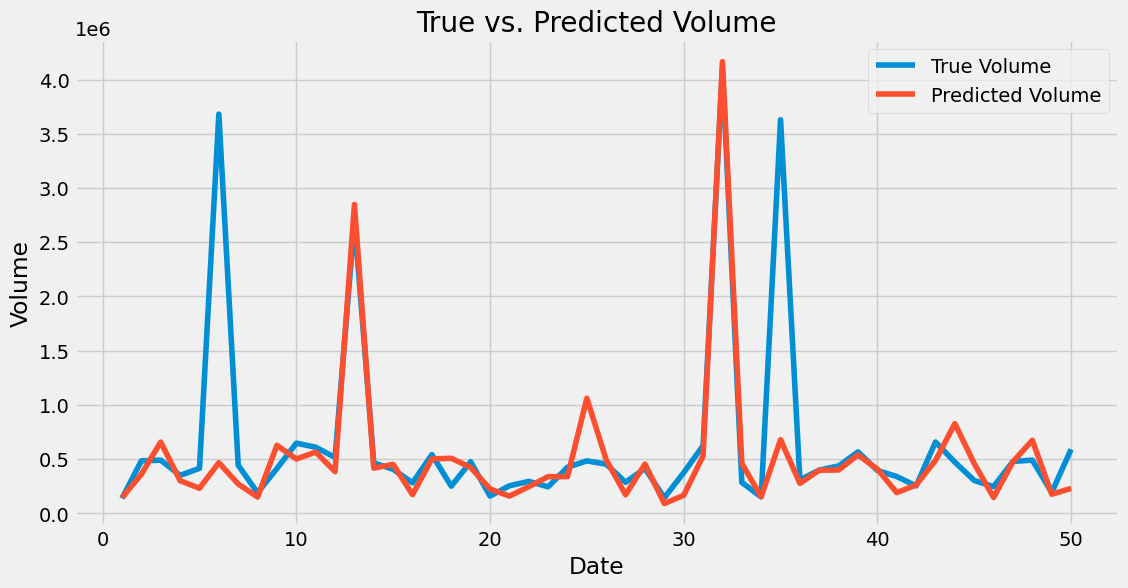

In [235]:
# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(result_data['Sno'], result_data['y_pred'], label='True Volume')
plt.plot(result_data['Sno'], result_data['y_test'], label='Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('True vs. Predicted Volume')
plt.legend()
plt.show()

In [236]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Calculate the average of each column for the last 7 days' data
average_values = df.iloc[-7:].drop(columns=['Volume']).mean()
next_day_vol = random_forest_vol.predict(average_values.values.reshape(1, -1))

# Print or use the predicted Close price as needed
print("Predicted Volume for the Next Day:", next_day_vol[0])


Predicted Volume for the Next Day: 5343204.27


<ipython-input-236-7a9543df9134>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_values = df.iloc[-7:].drop(columns=['Volume']).mean()
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Random Forest for low

In [237]:
# Selecting the relevant columns
features = ['Open', 'High', 'Close', 'Volume', 'macd', 'signal', 'hist']
target = ['Low']

data_features = data[features]
data_target = data[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=42)

# Creating and training the Random Forest model
random_forest_low = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_low.fit(X_train, y_train.values.ravel())

# Predicting on the test set
y_pred = random_forest_low.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 9.944549162062124


In [238]:
# Create a new DataFrame
sno = np.arange(1, len(y_pred) + 1)
result_data = pd.DataFrame({'Sno': sno, 'y_test': y_test.values.ravel(), 'y_pred': y_pred})

result_data.head()

,Sno,y_test,y_pred
0,1,149.050003,149.082500
1,2,167.199997,167.268504
2,3,171.600006,172.511501
3,4,185.500000,185.612500
4,5,148.500000,148.534998


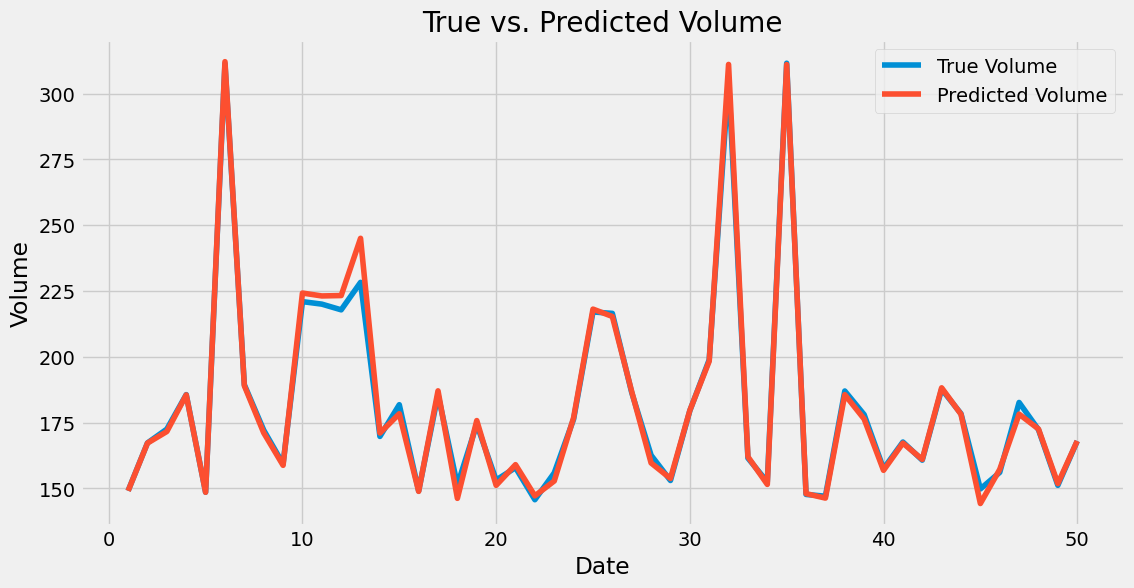

In [239]:
# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(result_data['Sno'], result_data['y_pred'], label='True Volume')
plt.plot(result_data['Sno'], result_data['y_test'], label='Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('True vs. Predicted Volume')
plt.legend()
plt.show()

In [240]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Calculate the average of each column for the last 7 days' data
average_values = df.iloc[-7:].drop(columns=['Volume']).mean()
next_day_low = random_forest_close.predict(average_values.values.reshape(1, -1))

# Print or use the predicted Close price as needed
print("Predicted Low for the Next Day:", next_day_low[0])


Predicted Low for the Next Day: 311.4649983215332


<ipython-input-240-f34e8e8ad21e>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_values = df.iloc[-7:].drop(columns=['Volume']).mean()
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


MACD

In [241]:
# Import date and timedelta class
# from datetime module
from datetime import date
from datetime import timedelta

# Get today's date
today = date.today()
print("Today is: ", today)

# Yesterday date
yesterday = today - timedelta(days = 1)
print("Yesterday was: ", yesterday)

Today is:  2023-09-03
Yesterday was:  2023-09-02


In [242]:
#  end_date = pd.Timestamp.now()
#  end_date

In [243]:
pd.datetime.now().strftime("%Y-%m-%d")

<ipython-input-243-8feb89a2cc80>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.now().strftime("%Y-%m-%d")


'2023-09-03'

In [244]:
# Yesterday date
yesterday = today - timedelta(days = 1)
date = str(yesterday)

In [245]:
print(next_day_open[0])
print(next_day_high[0])
print(next_day_low[0])
print(next_day_close[0])
print(next_day_vol[0])

304.94200103759766
311.5204975891113
311.4649983215332
311.1504981994629
5343204.27


In [246]:
df

,Date,Open,High,Low,Close,Volume,macd,signal,hist
0,2022-09-05,166.800003,171.850006,166.350006,167.000000,834555,0.000000,0.000000,0.000000
1,2022-09-06,168.300003,169.850006,162.500000,165.500000,619203,-0.119658,-0.023932,-0.095726
2,2022-09-07,164.250000,170.899994,163.500000,169.649994,495831,0.119010,0.004657,0.114353
3,2022-09-08,171.000000,171.899994,165.600006,166.600006,372822,0.061340,0.015993,0.045347
4,2022-09-09,168.800003,170.399994,166.250000,167.600006,390411,0.095231,0.031841,0.063390
...,...,...,...,...,...,...,...,...,...
243,2023-08-28,312.549988,325.950012,311.049988,323.649994,4164391,22.720278,14.055499,8.664779
244,2023-08-29,326.000000,328.299988,315.549988,321.299988,1716976,25.435906,16.331580,9.104326
245,2023-08-30,320.000000,321.299988,311.000000,315.750000,679698,26.830932,18.431450,8.399482
246,2023-08-31,315.799988,320.899994,312.100006,316.649994,468158,27.689930,20.283146,7.406784


In [247]:
row = [date, next_day_open[0], next_day_high[0], next_day_low[0],next_day_close[0],next_day_vol[0],'NULL','NULL','NULL']
df.loc[len(df.index)] = row

In [248]:
df

,Date,Open,High,Low,Close,Volume,macd,signal,hist
0,2022-09-05 00:00:00,166.800003,171.850006,166.350006,167.000000,834555.00,0.0,0.0,0.0
1,2022-09-06 00:00:00,168.300003,169.850006,162.500000,165.500000,619203.00,-0.119658,-0.023932,-0.095726
2,2022-09-07 00:00:00,164.250000,170.899994,163.500000,169.649994,495831.00,0.11901,0.004657,0.114353
3,2022-09-08 00:00:00,171.000000,171.899994,165.600006,166.600006,372822.00,0.06134,0.015993,0.045347
4,2022-09-09 00:00:00,168.800003,170.399994,166.250000,167.600006,390411.00,0.095231,0.031841,0.06339
...,...,...,...,...,...,...,...,...,...
244,2023-08-29 00:00:00,326.000000,328.299988,315.549988,321.299988,1716976.00,25.435906,16.33158,9.104326
245,2023-08-30 00:00:00,320.000000,321.299988,311.000000,315.750000,679698.00,26.830932,18.43145,8.399482
246,2023-08-31 00:00:00,315.799988,320.899994,312.100006,316.649994,468158.00,27.68993,20.283146,7.406784
247,2023-09-01 00:00:00,316.950012,321.700012,316.500000,318.000000,452734.00,28.155073,21.857532,6.297541


In [249]:
# Define the get_macd function
def get_macd(price, slow, fast, smooth):
    exp1 = price['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = price['Close'].ewm(span=slow, adjust=False).mean()

    macd = pd.DataFrame(exp1 - exp2).rename(columns={'Close': 'macd'})
    signal = macd.ewm(span=smooth, adjust=False).mean().rename(columns={'macd': 'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns={0: 'hist'})

    frames = [price['Date'], macd, signal, hist]
    df = pd.concat(frames, join='inner', axis=1)
    return df

In [250]:
# Calculate MACD for the provided dataset
macd = get_macd(df, 26, 12, 9)
macd.tail()

,Date,macd,signal,hist
244,2023-08-29 00:00:00,25.435906,16.331580,9.104326
245,2023-08-30 00:00:00,26.830932,18.431450,8.399482
246,2023-08-31 00:00:00,27.689930,20.283146,7.406784
247,2023-09-01 00:00:00,28.155073,21.857532,6.297541
248,2023-09-02,27.652246,23.016475,4.635772


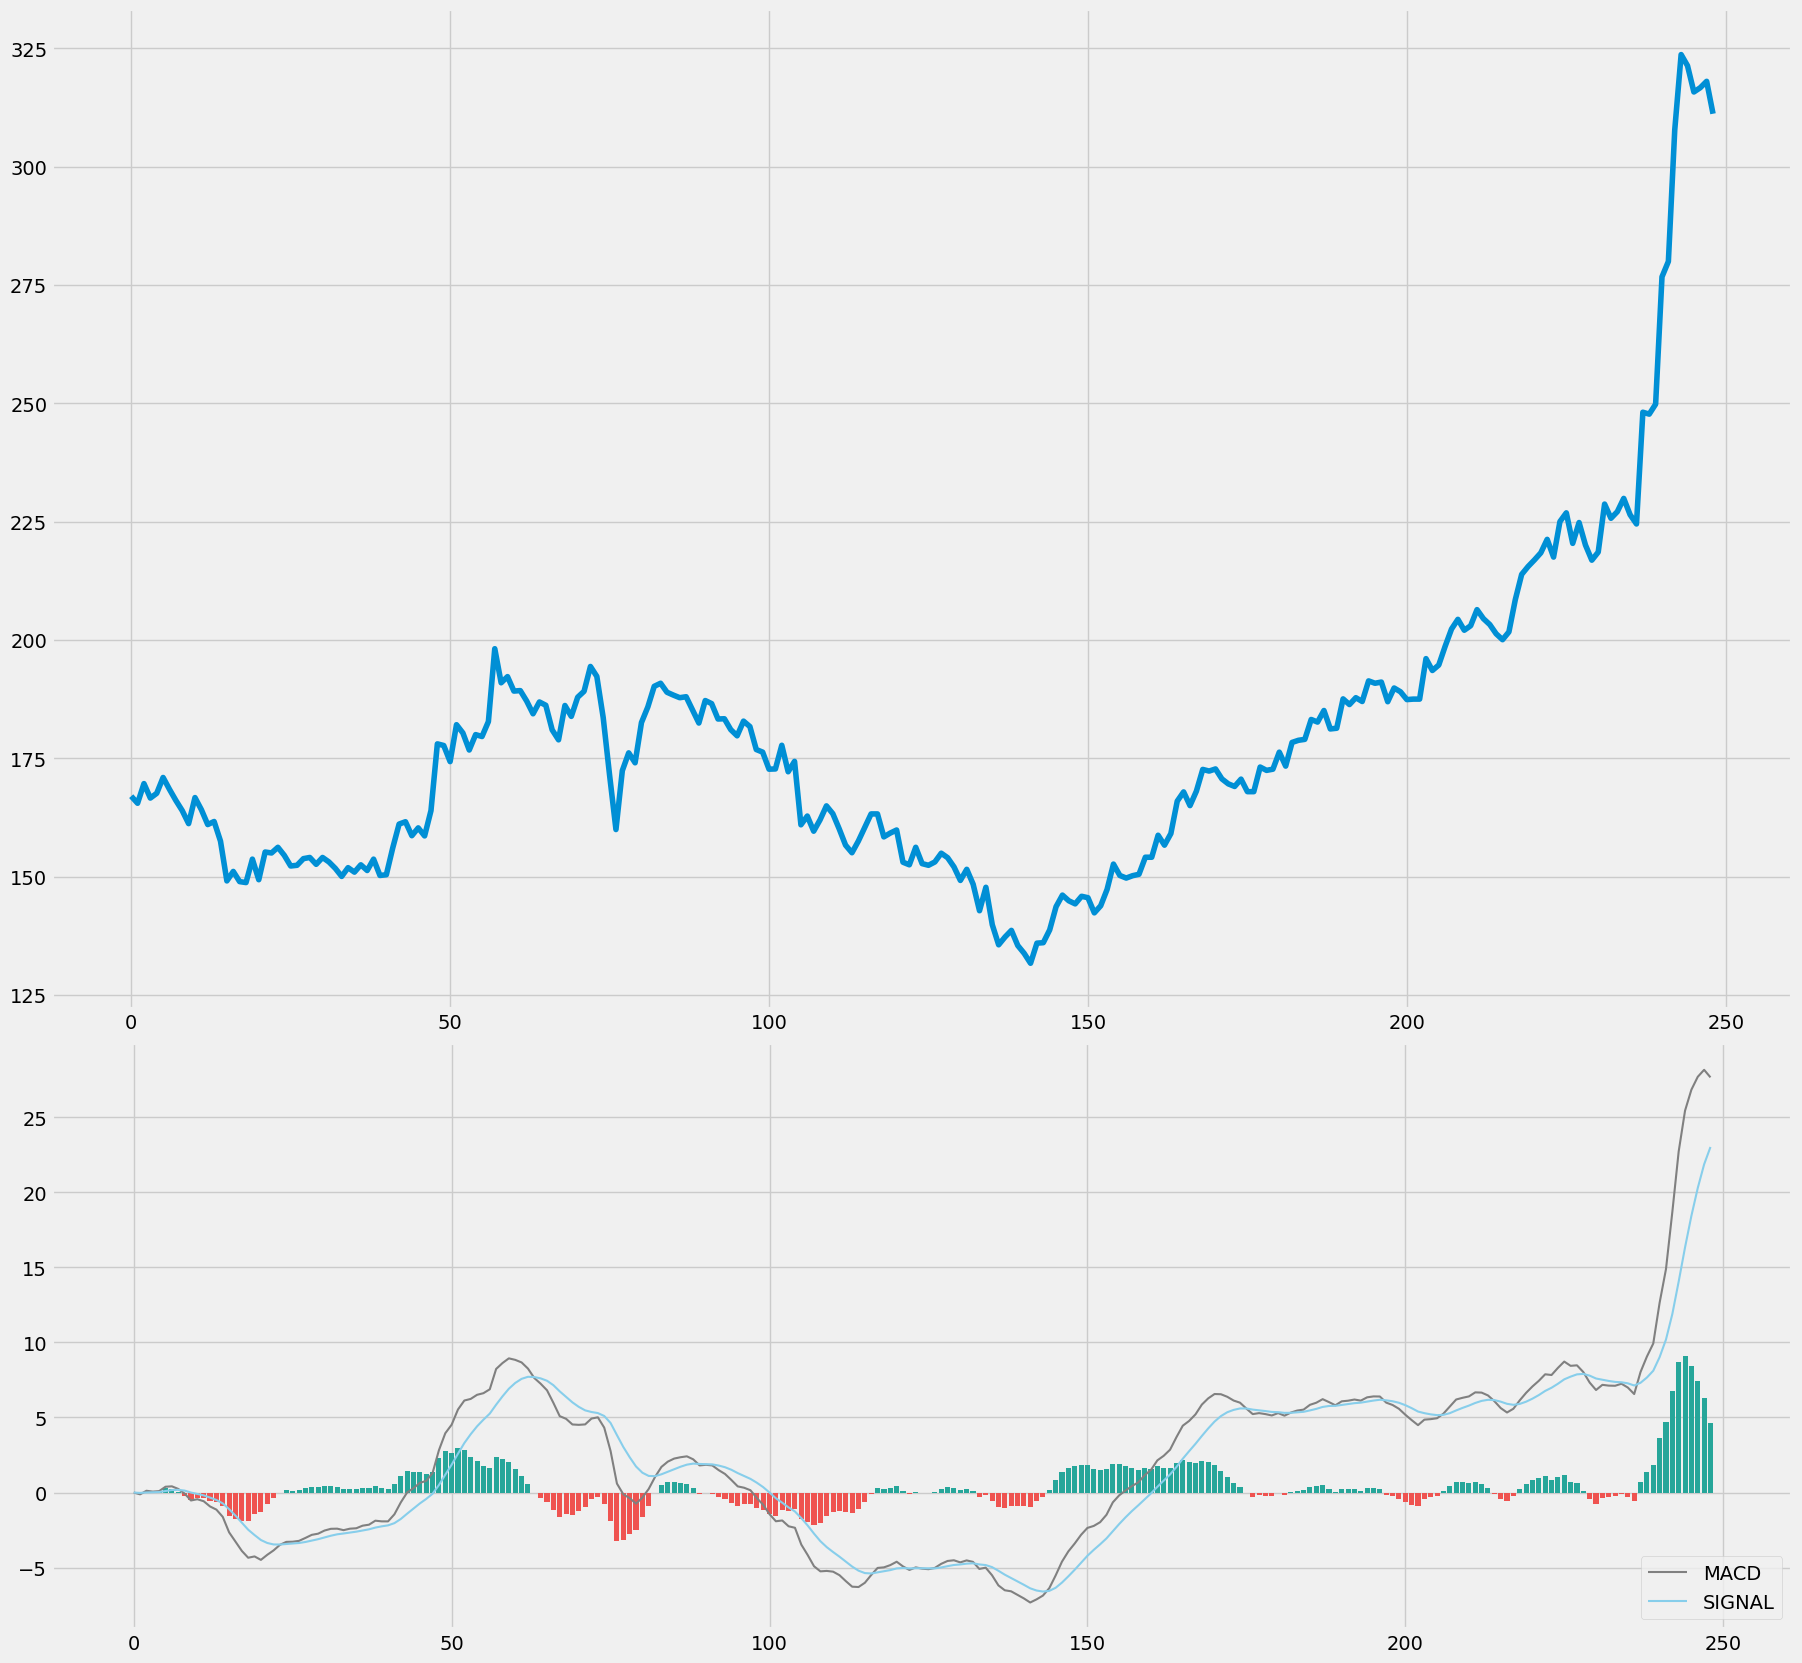

In [251]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
plt.style.use('fivethirtyeight')

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['Close'], macd['macd'], macd['signal'], macd['hist'])

In [252]:
import numpy as np

def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(df['Close'], macd)

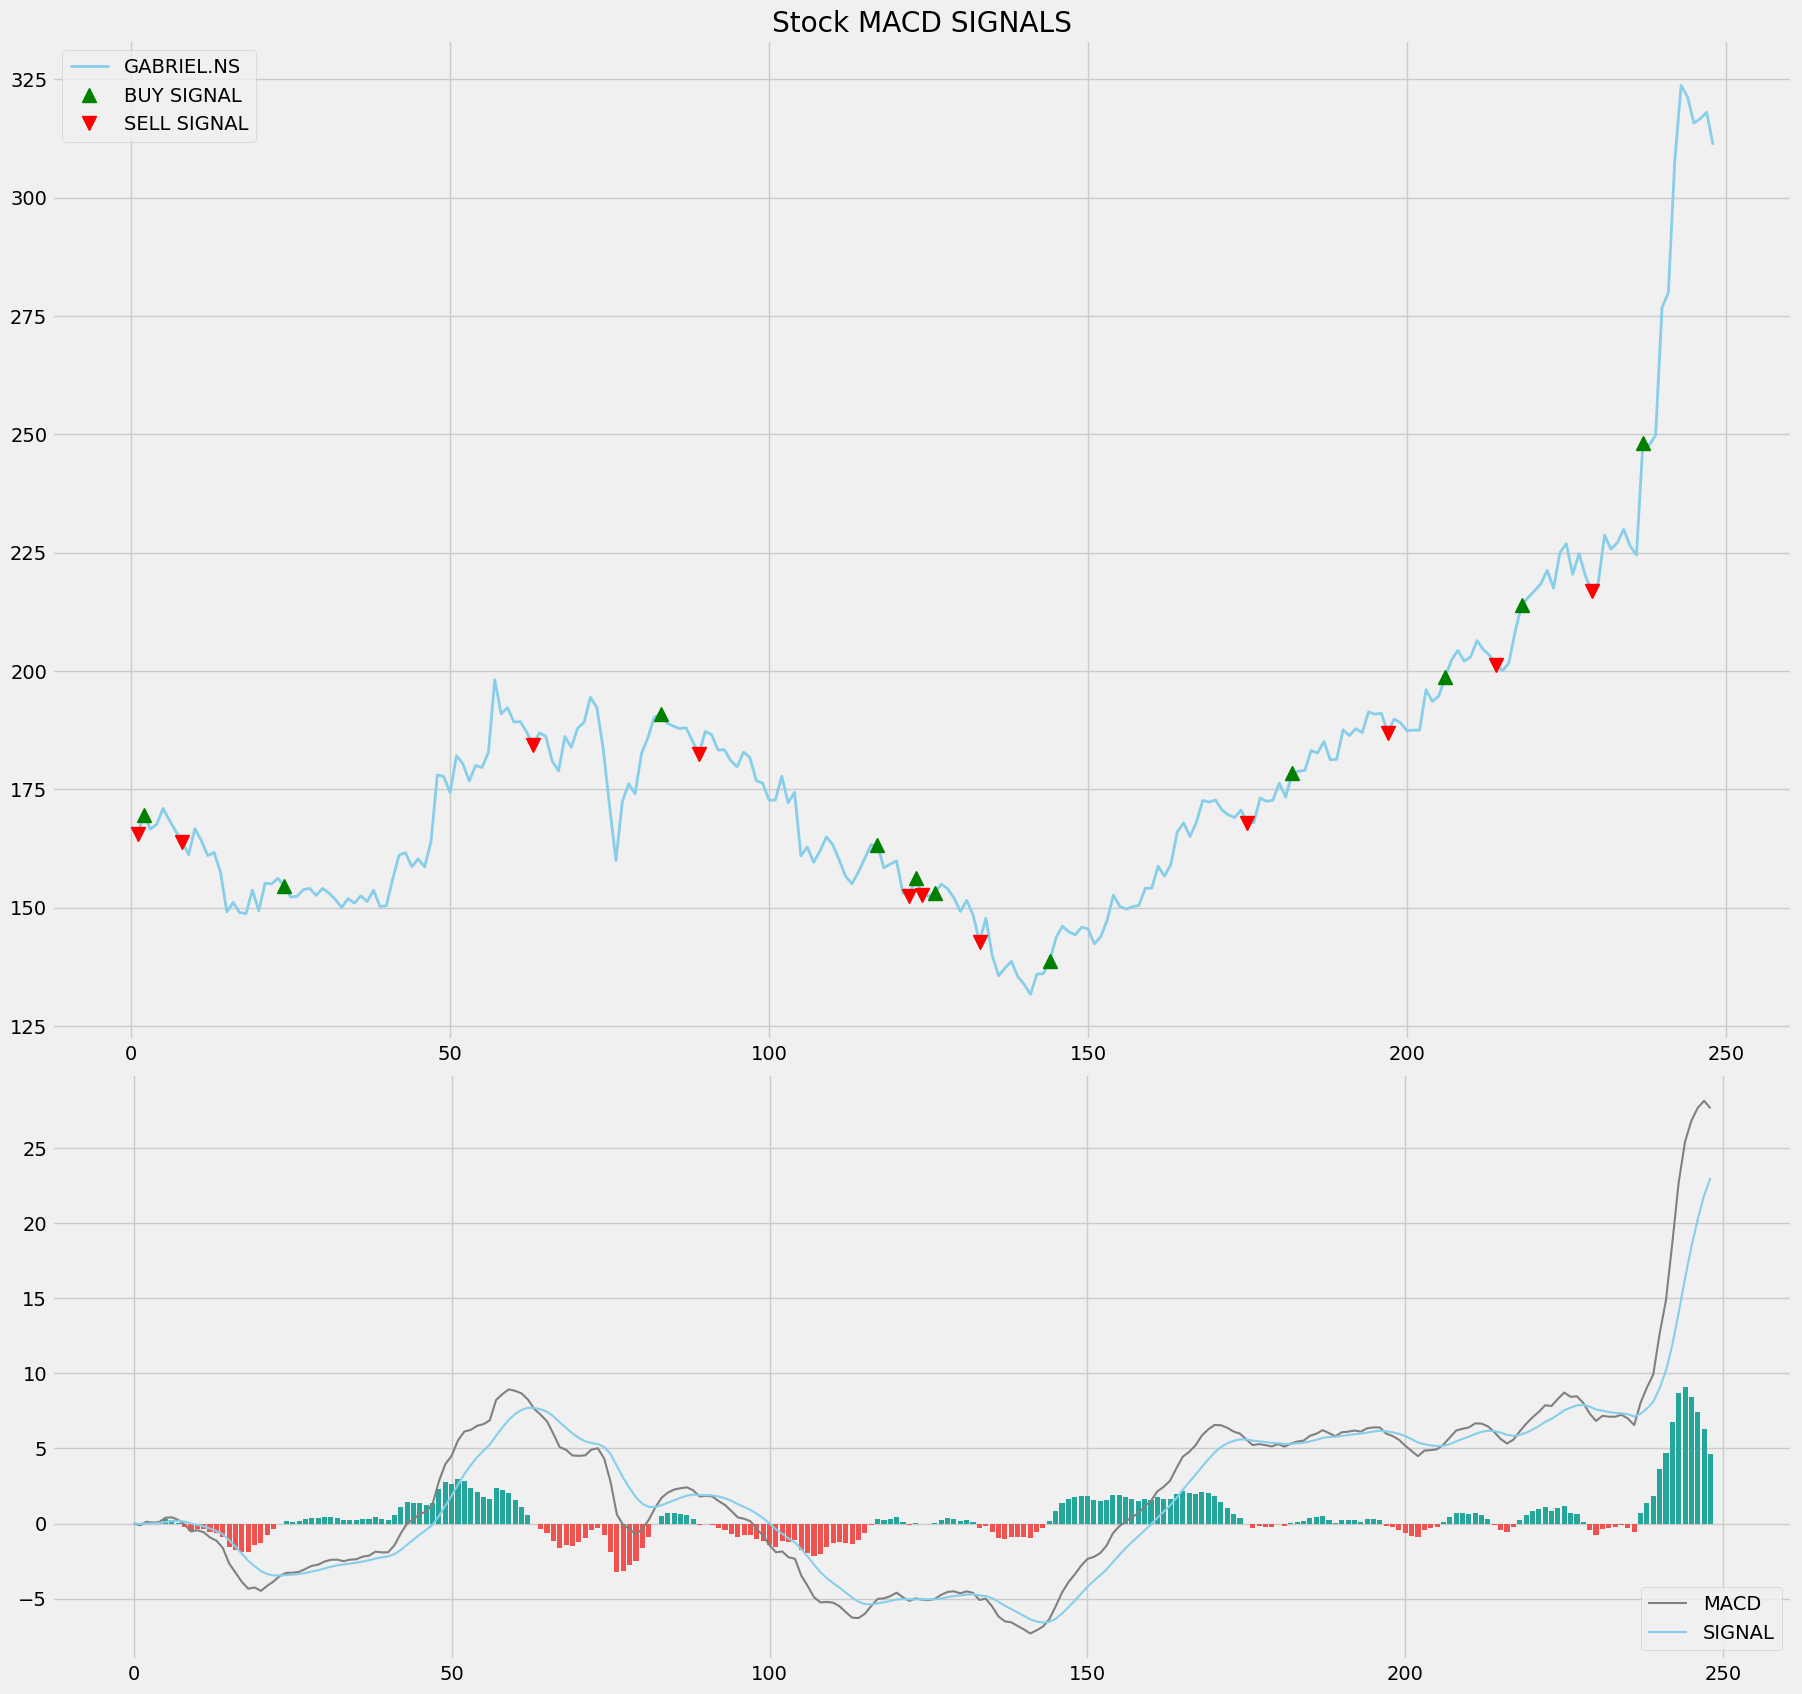

In [253]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['Close'], color = 'skyblue', linewidth = 2, label = stock_code)
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('Stock MACD SIGNALS')
ax2.plot(macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(macd)):
    if str(macd['hist'][i])[0] == '-':
        ax2.bar(macd.index[i], macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(macd.index[i], macd['hist'][i], color = '#26a69a')

plt.legend(loc = 'lower right')
plt.show()